In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
d = '/Users/abrahamn/Documents/Physics/papers/DishPapers/data/'
visdatdave =  np.load(d+'14.0m_dish_multi_baseline_visibilities_no_ground_drift_80x1080.0s_baseline_range_14.6-58.4_asm_all_sky_sprms_0.0_nside_256_derr_0.000ns_gerr_0.00dB_nrand_1_Tsys_220.0K_128x781.2_kHz_150.0_MHz_extpb_DDAN-128_137.5_MHz_achromatic_no_pfb.npz')
visdatairy = np.load(d+'14.0m_dish_multi_baseline_visibilities_no_ground_drift_80x1080.0s_baseline_range_14.6-58.4_asm_all_sky_sprms_0.0_nside_256_derr_0.000ns_gerr_0.00dB_nrand_1_Tsys_220.0K_128x781.2_kHz_150.0_MHz_extpb_Airy_137.5_MHz_achromatic_no_pfb.npz')
visdatrich = np.load(d+'14.0m_dish_multi_baseline_visibilities_no_ground_drift_80x1080.0s_baseline_range_14.6-58.4_asm_all_sky_sprms_0.0_nside_256_derr_0.000ns_gerr_0.00dB_nrand_1_Tsys_220.0K_128x781.2_kHz_150.0_MHz_extpb_RBAN-128H_137.5_MHz_achromatic_no_pfb.npz')

#richarea = 83.6
#davearea = 93.0
#airyarea = 154.3
omega_pp_rich = 0.0239813061344
omega_pp_dave = 0.0227262593512
omega_pp_airy = 0.0144454453097

In [3]:
visdatrich.files

['vis_freq',
 'bl',
 'timestamp',
 'skyvis_freq',
 'bl_length',
 'lst',
 'vis_noise_freq',
 'freq']

In [4]:
print visdatrich['bl'][1,:]
print visdatrich['bl'][15,:]

[  7.3       -12.6439709   0.       ]
[ 21.9        -37.93191269   0.        ]


In [5]:
freqs = visdatrich['freq']
dfHz = freqs[1]-freqs[0]

desiredcenterfreq = 150.e6
desiredcenterindex = int((desiredcenterfreq-freqs[0])/dfHz)
bandbandwidth = 95.e6 # Hz
#bandbandwidth = 20.e6 # Hz
desirednfreqs = bandbandwidth/dfHz
desiredindices = arange(len(freqs))[arange(int(desiredcenterindex-desirednfreqs/2),int(desiredcenterindex+desirednfreqs/2))]

bandfreqs = freqs[desiredindices]
numbandfreqs = len(bandfreqs)
dfHz = bandfreqs[1]-bandfreqs[0]
centerbandfreq = mean(bandfreqs)
centerbandlamda = 3.e8/centerbandfreq

z = 1420.e6/centerbandfreq-1
Ez = sqrt(.3*(1+z)**3+.7)
H0overc = 2.335e-4*100./70 # 1/Mpc, for H0=100km/s/Mpc

In [6]:
# Theory power spectrum from Zaki's PAPER-64 paper
theorydat2 = genfromtxt('/Users/abrahamn/Documents/Physics/papers/beamforming_errors_in_mwa_tiles/model_power_spectrum8_4.txt',skip_header=2)
theorykpara2 = theorydat2[:,0]
theorypowerspectrum2 = theorydat2[:,1]/abs(theorykpara2)**3*(2*pi**2)*1.e6
theorydelays2 = theorykpara2*(1+z)**2/(H0overc*2*pi*1420.e6*Ez)*1.e9

# Theory power spectrum generated by Aaron
theorydat = genfromtxt('/Users/abrahamn/Documents/Physics/papers/beamforming_errors_in_mwa_tiles/aaron_theory_power_spectrum.txt',skip_header=2)
theorykpara = theorydat[:,0]
theorypowerspectrum = theorydat[:,1]/abs(theorykpara)**3*(2*pi**2)*1.e6

theorydelays = theorykpara*(1+z)**2/(H0overc*2*pi*1420.e6*Ez)*1.e9

#blhorizondelayns = array(blmeters)*3.28
datadelays = roll(fft.fftfreq(numbandfreqs, d=dfHz),numbandfreqs/2)*1.e9 # df as defined above i
datakpara = datadelays*1.e-9*(H0overc*2*pi*1420.e6*Ez)/(1+z)**2

In [7]:
# See Section 2 of http://iopscience.iop.org/0004-637X/804/1/14/pdf/0004-637X_804_1_14.pdf
# for details on conversion from FFT of visibilities to cosmological power spectrum units

import scipy.signal

kb=1.38e-23 # J/K
D = 9285.5 # LOS comoving distance to z=8.5
H0overc = 2.335e-4*100./70 # 1/Mpc, for H0=100km/s/Mpc
f21 = 1420.e6

def vis_to_delay_spec(vis,omega_pp):
    wind = scipy.signal.blackmanharris(numbandfreqs)
    vis_ft = roll(fft.fft(vis*wind),numbandfreqs/2)/sqrt(np.mean(wind**2))
    
    deltaD = bandbandwidth*(1+z)**2/(f21*Ez*H0overc)
    units = D**2*deltaD*centerbandlamda**2/bandbandwidth**2*(1.e-26*dfHz)**2*(.5*centerbandlamda**2/kb)**2*(1.e6)
    
    #print deltaD/bandbandwidth
    datadelays = roll(fft.fftfreq(numbandfreqs, d=dfHz),numbandfreqs/2)*1.e9 # df as defined above i
    
    #print units
    return datadelays,vis_ft*sqrt(units)

In [8]:
fig = plt.figure(num=None, figsize=(7, 5), dpi=80)

delays,visrich_delayspec_shortbl = vis_to_delay_spec(visdatrich['skyvis_freq'][2,desiredindices,LSTindex60deg],omega_pp_rich)

ax1 = fig.add_subplot(111)
ax1.semilogy(delays, abs(visrich_delayspec_shortbl)**2 ,'b',linewidth=2,label='CST')
ax1.grid()
plotjunk(ax1,14.6*3.,[-75.*2,75.*2],showlegend=True)

NameError: name 'LSTindex60deg' is not defined

In [9]:
matplotlib.rcParams.update({'font.size': 18})

def plotjunk(ax,hordelay,myxlim,showlegend=False):
    # cosmology power spectra
    #ax.semilogy(theorydelays,theorypowerspectrum*1.e-6,'k:',linewidth=2,label='1D theory')
    #ax.semilogy(-theorydelays,theorypowerspectrum*1.e-6,'k:',linewidth=2)
    if showlegend: plt.legend(fontsize=10,loc=8)

    # other plotting stuff
    ax.semilogy([-hordelay,-hordelay],[1.e-6,2.e18],'k-')
    ax.semilogy([hordelay,hordelay],[1.e-6,2.e18],'k-')
    plt.ylim([1.e3,1.e17])
    plt.xlim(myxlim)
    plt.xlabel(r"$\tau$ (ns)")
    plt.ylabel(r"$P(k)$  $(\mathrm{h}^{-3} \mathrm{Mpc}^3 \mathrm{mK}^2)$")
    ax2 = ax.twiny()
    #delayticks = ax.get_xticks()
    kparaticks = array([-.1,-.05,0,.05,.1])
    kparaticksdelays = kparaticks*(1+z)**2/(H0overc*2*pi*1420.e6*Ez)*1.e9
    ax2.set_xticks(kparaticksdelays)
    ax2.set_xbound(ax1.get_xbound())
    ax2.set_xticklabels(["%.2f"%kpara for kpara in kparaticks])
    ax2.set_xlabel(r"$k_\parallel$ $(\mathrm{h} \mathrm{Mpc}^{-1})$")

In [10]:
print visdatrich['freq'].shape
print visdatrich['bl'].shape
print visdatrich['lst'].shape
print visdatrich['skyvis_freq'].shape

(128,)
(30, 3)
(80,)
(30, 128, 80)


In [11]:
LSTindex0deg = 0
LSTindex60deg = 13

In [12]:
LSTindicestoplot = [0,7,13,19,25]
LSTs[LSTindicestoplot]

NameError: name 'LSTs' is not defined

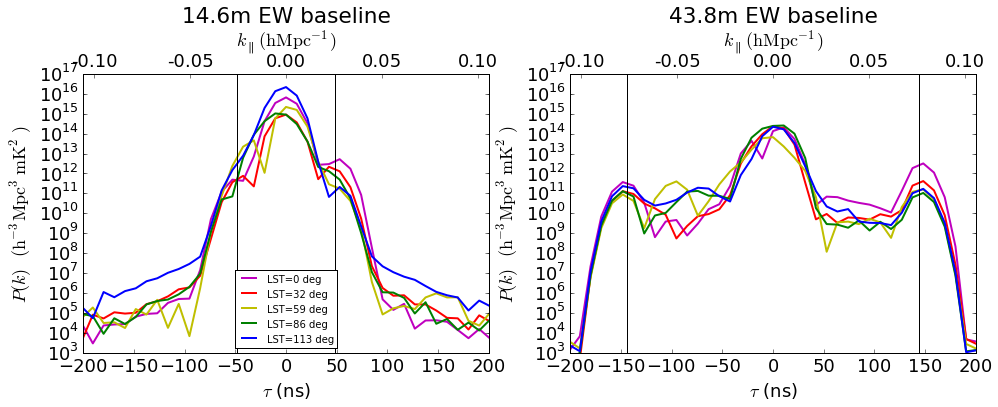

In [13]:
fig = plt.figure(num=None, figsize=(16, 5), dpi=80)

cols = ['m','r','y','g','b','c','k','k--']
LSTs = visdatrich['lst']

for i in range(len(LSTindicestoplot)):
    LSTi = LSTindicestoplot[i]
    delays,visrich_delayspec_shortbl = vis_to_delay_spec(visdatdave['skyvis_freq'][0,desiredindices,LSTi],omega_pp_rich)
    
    delays,visrich_delayspec_longbl = vis_to_delay_spec(visdatdave['skyvis_freq'][17,desiredindices,LSTi],omega_pp_rich)
    
    ax1 = fig.add_subplot(121)
    ax1.semilogy(delays, abs(visrich_delayspec_shortbl)**2 ,cols[i],linewidth=2, label='LST='+str(int(LSTs[LSTi]))+' deg')
    plt.title('14.6m EW baseline\n\n')
    if i==len(LSTindicestoplot)-1: plotjunk(ax1,14.6*3.28,[-200.,200.],showlegend=True)

    ax11 = fig.add_subplot(122)
    ax11.semilogy(delays, abs(visrich_delayspec_longbl)**2 ,cols[i],linewidth=2)
    plt.title('43.8m EW baseline\n\n')
    if i==len(LSTindicestoplot)-1: plotjunk(ax11,43.8*3.28,[-200,200.])

plt.savefig('nithya_fg_pspec_all_lst.pdf',bbox_inches='tight')

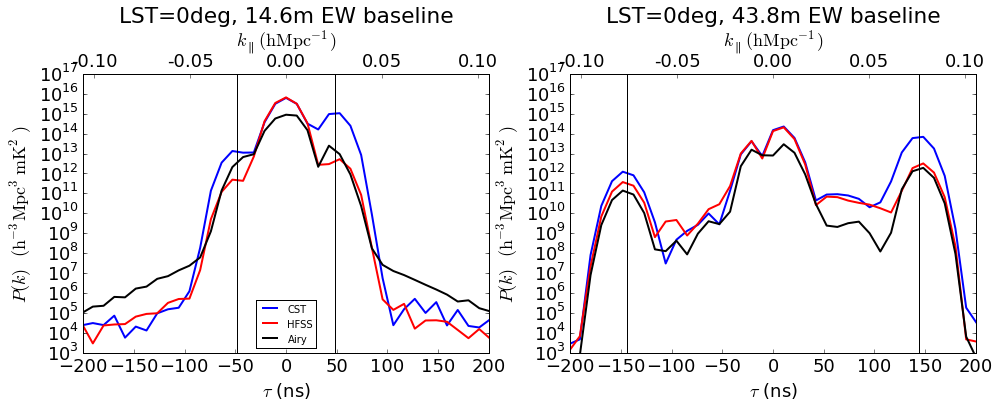

In [14]:
fig = plt.figure(num=None, figsize=(16, 5), dpi=80)

delays,visrich_delayspec_shortbl = vis_to_delay_spec(visdatrich['skyvis_freq'][0,desiredindices,LSTindex0deg],omega_pp_rich)
delays,visdave_delayspec_shortbl = vis_to_delay_spec(visdatdave['skyvis_freq'][0,desiredindices,LSTindex0deg],omega_pp_dave)
delays,visairy_delayspec_shortbl = vis_to_delay_spec(visdatairy['skyvis_freq'][0,desiredindices,LSTindex0deg],omega_pp_airy)

delays,visrich_delayspec_longbl = vis_to_delay_spec(visdatrich['skyvis_freq'][17,desiredindices,LSTindex0deg],omega_pp_rich)
delays,visdave_delayspec_longbl = vis_to_delay_spec(visdatdave['skyvis_freq'][17,desiredindices,LSTindex0deg],omega_pp_dave)
delays,visairy_delayspec_longbl = vis_to_delay_spec(visdatairy['skyvis_freq'][17,desiredindices,LSTindex0deg],omega_pp_airy)

ax1 = fig.add_subplot(121)
ax1.semilogy(delays, abs(visrich_delayspec_shortbl)**2 ,'b',linewidth=2,label='CST')
ax1.semilogy(delays, abs(visdave_delayspec_shortbl)**2 ,'r',linewidth=2,label='HFSS')
ax1.semilogy(delays, abs(visairy_delayspec_shortbl)**2 ,'k',linewidth=2,label='Airy')
#ax1.semilogy(delays, abs(visrich_delayspec_shortbl-visdave_delayspec_shortbl)**2 ,'c--',linewidth=2,label='CST-HFSS')
plt.title('LST=0deg, 14.6m EW baseline\n\n')
plotjunk(ax1,14.6*3.28,[-200.,200.],showlegend=True)

ax11 = fig.add_subplot(122)
ax11.semilogy(delays, abs(visrich_delayspec_longbl)**2 ,'b',linewidth=2,label='CST')
ax11.semilogy(delays, abs(visdave_delayspec_longbl)**2 ,'r',linewidth=2,label='HFSS')
ax11.semilogy(delays, abs(visairy_delayspec_longbl)**2 ,'k',linewidth=2,label='Airy')
#ax11.semilogy(delays, abs(visrich_delayspec_longbl-visdave_delayspec_longbl)**2 ,'c--',linewidth=2,label='CST-HFSS')
plt.title('LST=0deg, 43.8m EW baseline\n\n')
plotjunk(ax11,43.8*3.28,[-200,200.])

plt.savefig('nithya_fg_pspec_lst0deg.pdf',bbox_inches='tight')

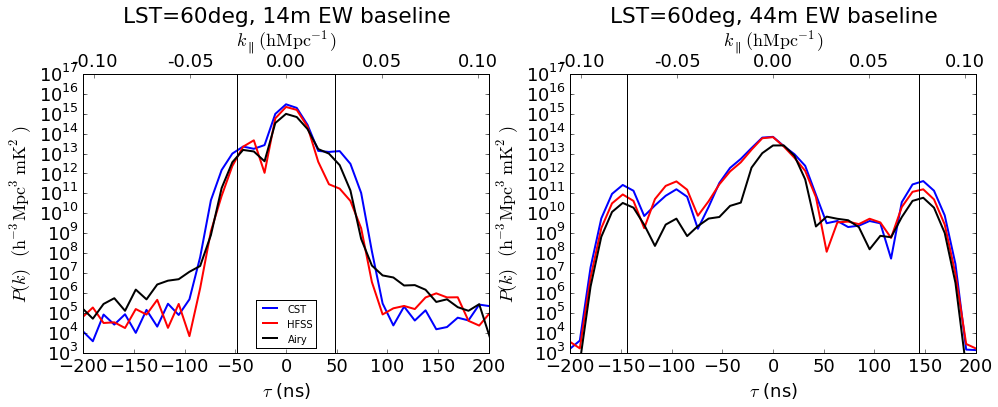

In [15]:
fig = plt.figure(num=None, figsize=(16, 5), dpi=80)

delays,visrich_delayspec_shortbl = vis_to_delay_spec(visdatrich['skyvis_freq'][0,desiredindices,LSTindex60deg],omega_pp_rich)
delays,visdave_delayspec_shortbl = vis_to_delay_spec(visdatdave['skyvis_freq'][0,desiredindices,LSTindex60deg],omega_pp_dave)
delays,visairy_delayspec_shortbl = vis_to_delay_spec(visdatairy['skyvis_freq'][0,desiredindices,LSTindex60deg],omega_pp_airy)

delays,visrich_delayspec_longbl = vis_to_delay_spec(visdatrich['skyvis_freq'][17,desiredindices,LSTindex60deg],omega_pp_rich)
delays,visdave_delayspec_longbl = vis_to_delay_spec(visdatdave['skyvis_freq'][17,desiredindices,LSTindex60deg],omega_pp_dave)
delays,visairy_delayspec_longbl = vis_to_delay_spec(visdatairy['skyvis_freq'][17,desiredindices,LSTindex60deg],omega_pp_airy)

ax1 = fig.add_subplot(121)
ax1.semilogy(delays, abs(visrich_delayspec_shortbl)**2 ,'b',linewidth=2,label='CST')
ax1.semilogy(delays, abs(visdave_delayspec_shortbl)**2 ,'r',linewidth=2,label='HFSS')
ax1.semilogy(delays, abs(visairy_delayspec_shortbl)**2 ,'k',linewidth=2,label='Airy')
#ax1.semilogy(delays, abs(visrich_delayspec_shortbl-visdave_delayspec_shortbl)**2 ,'c--',linewidth=2,label='CST-HFSS')
plt.title('LST=60deg, 14m EW baseline\n\n')
plotjunk(ax1,14.6*3.28,[-200.,200.],showlegend=True)

ax11 = fig.add_subplot(122)
ax11.semilogy(delays, abs(visrich_delayspec_longbl)**2 ,'b',linewidth=2,label='CST')
ax11.semilogy(delays, abs(visdave_delayspec_longbl)**2 ,'r',linewidth=2,label='HFSS')
ax11.semilogy(delays, abs(visairy_delayspec_longbl)**2 ,'k',linewidth=2,label='Airy')
#ax11.semilogy(delays, abs(visrich_delayspec_longbl-visdave_delayspec_longbl)**2 ,'c--',linewidth=2,label='CST-HFSS')
plt.title('LST=60deg, 44m EW baseline\n\n')
plotjunk(ax11,43.8*3.28,[-200,200.])

plt.savefig('nithya_fg_pspec_lst60deg.pdf',bbox_inches='tight')